# Notes
* Here are some of the problems you could run into:
  
* You may be faced with the problem of gradients growing ever smaller or larger,
  * when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
   
*  You might not have enough training data for such a large network, or it might be too costly to label.
*   Training may be extremely slow.
*    A model with millions of parameters would severely risk overfitting the training
     *    set, especially if there are not enough training instances or if they are too noisy.
*    we will look at transfer learning and unsupervised pretraining, which can help you 
     *    tackle complex tasks even when you have little labeled data. 
     *    Using various optimizers that can speed up training large models tremendously.

# Training Deep Neural Networks

* Better initialization
  
* Other Activation functions
* Gradient Clipping
* Better Optimizers
* Transfer Learning , Auxillary output training 
  

# Vanishing / Exploding Gradients problem

* Unfortunately, gradients often get smaller and smaller as the algorithm progresses
  * down to the lower layers. As a result, the gradient descent update leaves the lower
  * layers’ connection weights virtually unchanged, and training never converges to a
  * good solution. This is called the **vanishing gradients problem.**

* due to the above, NN were **abandoned** in the early 2000s
* one of the **suspects** was SIGMOID activaiton funciton and the weight initalization technique used at that time
* that has a normal distribution with a mean of 0 and a standard deviation of 1
* The saturation effect by the sigmoid function is worse and has a mean of 0.5 not 0
  * the **tanh** function has a mean of 0 and behaves slightly better than the sigmoid in DNN

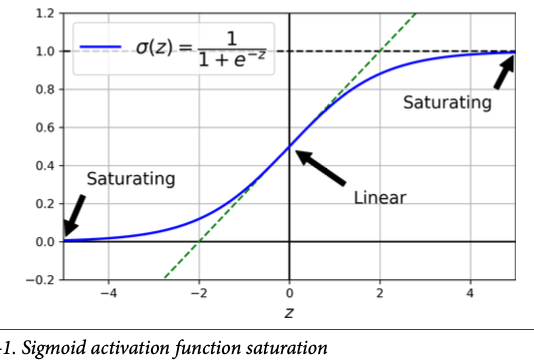

# Glorot & HE initalization

# Better Activation Functions

# Gradient clipping

# re-using pre trained layers